In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_kato_data
import zimmer.plotting as zplt
from zimmer.observations import HierarchicalIndependentAutoRegressiveObservations, HierarchicalAutoRegressiveObservations 
from zimmer.transitions import HierarchicalRecurrentTransitions, HierarchicalRecurrentOnlyTransitions
from zimmer.util import cached

from ssm.models import HMM
from ssm.core import _HMM
from ssm.init_state_distns import InitialStateDistribution
from ssm.transitions import RecurrentTransitions, InputDrivenTransitions, StationaryTransitions, \
    NeuralNetworkRecurrentTransitions, RecurrentOnlyTransitions
from ssm.observations import IndependentAutoRegressiveObservations

from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [2]:
# Specify outputs
results_dir = "results/kato/2018-08-29"

In [3]:
# Load the data
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=False, signal="dff")
ys = [trend_filter(y) for y in ys]


K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

Only including named neurons.
59 neurons across all 5 worms


In [4]:
D = 10   # dimensionality of continuous latent states
M = 0   # dimensionality of input

# Dimensionality reduction on $\Delta$F/F 

In [5]:
# Run PCA to get a 3d projection of the data
from scipy.ndimage import gaussian_filter1d
from ssm.preprocessing import pca_with_imputation
pca, xs = pca_with_imputation(D, ys, ms)
# xs = [gaussian_filter1d(x, 1, axis=0) for x in xs]
# dxs = [gaussian_filter1d(np.gradient(x, axis=0), 1, axis=0) for x in xs]

lim = 1.1 * abs(np.vstack(xs)).max()

In [6]:
# plt.figure(figsize=(12, 16))
# for w, (x, z) in enumerate(zip(xs, z_trues)):
#     for d in range(1, D):
#         ax = plt.subplot(D, W, (d-1) * W + w+1)
#         zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, d), ax=ax)
#         plt.ylabel("PC {}".format(d+1) if w == 0 else "")
#         plt.title("worm {}".format(w+1))

# plt.suptitle("Continuous Latent States (Zimmer Labels)")
# plt.tight_layout()

# Split into train/test/validation

In [7]:
chunk = 250
train_frac = 0.7
val_frac = 0.15
all_ys = []
all_xs = []
all_ms = []
all_tags = []
all_z_trues = []
all_choices = []
for tag, (y, x, m, ztr) in enumerate(zip(ys, xs, ms, z_trues)):
    T = y.shape[0]
    C = 0
    for start in range(0, T, chunk):
        stop = min(start+chunk, T)
        all_ys.append(y[start:stop])
        all_xs.append(x[start:stop])
        all_ms.append(m[start:stop])
        all_z_trues.append(ztr[start:stop])
        all_tags.append(tag)
        C += 1
        
    # assign some of the data to train, val, and test
    choices = -1 * np.ones(C)
    choices[:int(train_frac * C)] = 0
    choices[int(train_frac * C):int((train_frac + val_frac) * C)] = 1
    choices[int((train_frac + val_frac) * C):] = 2
    choices = choices[np.random.permutation(C)]
    all_choices.append(choices)

all_choices = np.concatenate(all_choices)
get = lambda arr, chc: [x for x, c in zip(arr, all_choices) if c == chc]

train_ys = get(all_ys, 0)
train_xs = get(all_xs, 0)
train_ms = get(all_ms, 0)
train_zs = get(all_z_trues, 0)
train_tags = get(all_tags, 0)

val_ys = get(all_ys, 1)
val_xs = get(all_xs, 1)
val_ms = get(all_ms, 1)
val_zs = get(all_z_trues, 1)
val_tags = get(all_tags, 1)

test_ys = get(all_ys, 2)
test_xs = get(all_xs, 2)
test_ms = get(all_ms, 2)
test_zs = get(all_z_trues, 2)
test_tags = get(all_tags, 2)

In [8]:
print("Training chunks per worm:   ", np.bincount(train_tags))
print("Validation chunks per worm: ", np.bincount(val_tags))
print("Testing chunks per worm:    ", np.bincount(test_tags))

Training chunks per worm:    [9 9 9 9 9]
Validation chunks per worm:  [2 2 2 2 2]
Testing chunks per worm:     [2 2 2 2 2]


# Fit an ARHMM to the continuous latent states, sweeping over number of discrete latent states

In [9]:
Ks = np.arange(2, 21, step=2)
transitionss = ["recurrent"]
observationss = ["ar"]

In [10]:
def _fit_hmm(K, transitions, observations):
    hmm = HMM(K, D, M, transitions=transitions, observations=observations)
    lps = hmm.fit(train_xs, method="em", num_em_iters=100)
    val_ll = hmm.log_likelihood(val_xs)
    return hmm, lps, val_ll

In [11]:
hmm_results = {}
for K in Ks:
    for transitions in transitionss:
        for observations in observationss:
            hmm_results_name = "hmm_{}_{}_K{}".format(transitions, observations, K)
            fit = cached(results_dir, hmm_results_name)(_fit_hmm)
            
            print("Fitting ", hmm_results_name)
            hmm_results[hmm_results_name] = fit(K, transitions, observations)

Fitting  hmm_recurrent_ar_K2
Fitting  hmm_recurrent_ar_K4
Fitting  hmm_recurrent_ar_K6
Fitting  hmm_recurrent_ar_K8
Fitting  hmm_recurrent_ar_K10
Fitting  hmm_recurrent_ar_K12
Fitting  hmm_recurrent_ar_K14
Fitting  hmm_recurrent_ar_K16
Fitting  hmm_recurrent_ar_K18
Fitting  hmm_recurrent_ar_K20


# Fit hierarchical HMMs

In [12]:
def _fit_hierarchical_hmm(K, transitions, observations, hmm):
    # Construct the HMM components
    init_state_distn = InitialStateDistribution(K, D, M)

    transition_classes = dict(recurrent=HierarchicalRecurrentTransitions)
    transition_distn = transition_classes[transitions](K, D, W, M, eta=1e-4)
    
    observation_classes = dict(ar=HierarchicalAutoRegressiveObservations, 
                               independent_ar=HierarchicalIndependentAutoRegressiveObservations)
    observation_distn = observation_classes[observations](K, D, W, M, eta=1e-4)
    
    # Construct the HMM
    hhmm = _HMM(K, D, M, init_state_distn, transition_distn, observation_distn)

    # Initialize with the standard HMM
    hhmm.init_state_distn.params = copy.deepcopy(hmm.init_state_distn.params)
    hhmm.transitions.initialize_from_standard(hmm.transitions)
    hhmm.observations.initialize_from_standard(hmm.observations)

    # Fit
    lps = hhmm.fit(train_xs, tags=train_tags, method="em", num_em_iters=100, initialize=False)
    
    # Validate
    val_ll = hhmm.log_likelihood(val_xs, tags=val_tags)
    return hhmm, lps, val_ll

In [13]:
hhmm_results = {}
for K in Ks:
    for transitions in transitionss:
        for observations in observationss:
            # Get the HMM results
            hmm_results_name = "hmm_{}_{}_K{}".format(transitions, observations, K)
            hmm, _, _ = hmm_results[hmm_results_name]
            
            # Fit the Hierarchical HMM
            hhmm_results_name = "hhmm_{}_{}_K{}".format(transitions, observations, K)
            fit = cached(results_dir, hhmm_results_name)(_fit_hierarchical_hmm)
            print("Fitting ", hhmm_results_name)
            hhmm_results[hhmm_results_name] = fit(K, transitions, observations, hmm)

Fitting  hhmm_recurrent_ar_K2
Fitting  hhmm_recurrent_ar_K4
Fitting  hhmm_recurrent_ar_K6
Fitting  hhmm_recurrent_ar_K8
Fitting  hhmm_recurrent_ar_K10
Fitting  hhmm_recurrent_ar_K12
Fitting  hhmm_recurrent_ar_K14
Fitting  hhmm_recurrent_ar_K16
Fitting  hhmm_recurrent_ar_K18
Fitting  hhmm_recurrent_ar_K20


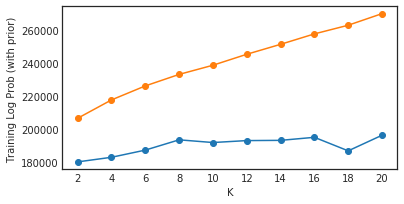

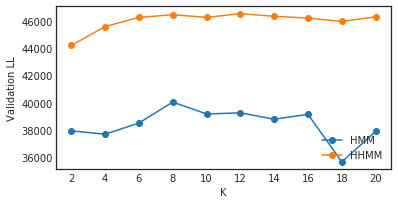

In [71]:
# Plot train and validation likelihoods
plt.figure(figsize=(6, 3))
hmm_train_lls = [hmm_results["hmm_recurrent_ar_K{}".format(K)][1][-1] for K in Ks]
hhmm_train_lls = [hhmm_results["hhmm_recurrent_ar_K{}".format(K)][1][-1] for K in Ks]
plt.plot(Ks, hmm_train_lls, '-o', label="HMM")
plt.plot(Ks, hhmm_train_lls, '-o', label="HHMM")
plt.xlabel("K")
plt.xticks(Ks)
plt.ylabel("Training Log Prob (with prior) ")

plt.figure(figsize=(6, 3))
hmm_val_lls = [hmm_results["hmm_recurrent_ar_K{}".format(K)][2] for K in Ks]
hhmm_val_lls = [hhmm_results["hhmm_recurrent_ar_K{}".format(K)][2] for K in Ks]
plt.plot(Ks, hmm_val_lls, '-o', label="HMM")
plt.plot(Ks, hhmm_val_lls, '-o', label="HHMM")
plt.xlabel("K")
plt.xticks(Ks)
plt.ylabel("Validation LL")
plt.legend(loc="lower right")

In [34]:
best_hhmm_K = 12
hhmm = hhmm_results["hhmm_recurrent_ar_K{}".format(best_hhmm_K)][0]

# Fit the HHMM to the full train and validation data

In [37]:
def _fit_to_all_data(hhmm):
    lps = hhmm.fit(train_xs + val_xs, tags=train_tags + val_tags, method="em", num_em_iters=100, initialize=False)
    return hhmm, lps

fit = cached(results_dir, "best_hhmm_{}".format(best_hhmm_K))(_fit_to_all_data)
hhmm, _ = fit(hhmm)

Iteration 0.  LP: 292883.7
Iteration 1.  LP: 293036.6
Iteration 2.  LP: 293104.7
Iteration 3.  LP: 293149.2
Iteration 4.  LP: 293179.4
Iteration 5.  LP: 293204.8
Iteration 6.  LP: 293224.8
Iteration 7.  LP: 293242.7
Iteration 8.  LP: 293255.0
Iteration 9.  LP: 293264.5
Iteration 10.  LP: 293272.5
Iteration 11.  LP: 293279.6
Iteration 12.  LP: 293286.3
Iteration 13.  LP: 293292.6
Iteration 14.  LP: 293299.6
Iteration 15.  LP: 293306.9
Iteration 16.  LP: 293313.8
Iteration 17.  LP: 293320.5
Iteration 18.  LP: 293328.9
Iteration 19.  LP: 293342.7
Iteration 20.  LP: 293350.7
Iteration 21.  LP: 293357.7
Iteration 22.  LP: 293365.0
Iteration 23.  LP: 293371.0
Iteration 24.  LP: 293376.1
Iteration 25.  LP: 293380.9
Iteration 26.  LP: 293385.5
Iteration 27.  LP: 293390.2
Iteration 28.  LP: 293394.4
Iteration 29.  LP: 293398.7
Iteration 30.  LP: 293403.4
Iteration 31.  LP: 293407.4
Iteration 32.  LP: 293411.2
Iteration 33.  LP: 293415.2
Iteration 34.  LP: 293419.5
Iteration 35.  LP: 293424.1
It

# Look at inferred state segmentations

In [38]:
z_infs = [hhmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]
hhmm.permute(find_permutation(np.concatenate(z_trues), np.concatenate(z_infs)))
z_infs = [hhmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]

In [39]:
np.bincount(np.concatenate(z_infs), minlength=8)

array([1912, 3137, 1136, 2001,  715, 1026, 1654,  370,  590, 2064, 1406,
        185])

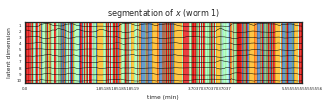

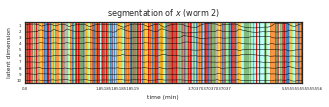

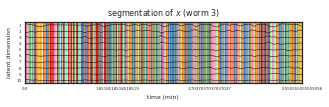

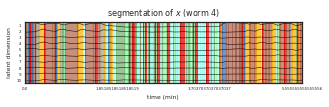

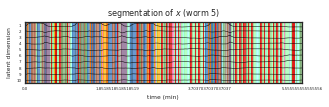

In [40]:
zplt.plot_latent_trajectories_vs_time(xs, z_infs, plot_slice=(0, 1000))

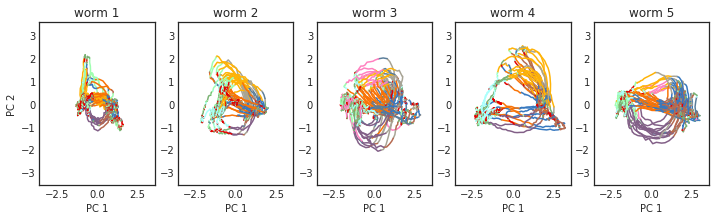

In [41]:
plt.figure(figsize=(12, 3))
for w, (x, z) in enumerate(zip(xs, z_infs)):
    ax = plt.subplot(1, W, w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 1), ax=ax)
    plt.ylabel("PC 2" if w == 0 else "")
    plt.xlabel("PC 1")
    plt.title("worm {}".format(w+1))
    

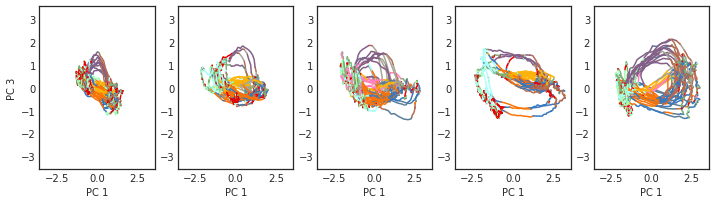

In [42]:
plt.figure(figsize=(12, 3))
for w, (x, z) in enumerate(zip(xs, z_infs)):
    ax = plt.subplot(1, W, w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 2), ax=ax)
    plt.ylabel("PC 3" if w == 0 else "")
    plt.xlabel("PC 1")

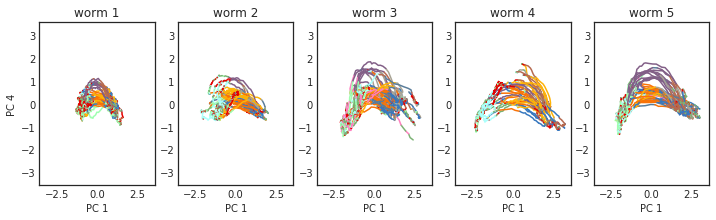

In [43]:
if D > 3:
    plt.figure(figsize=(12, 3))
    for w, (x, z) in enumerate(zip(xs, z_infs)):    
        ax = plt.subplot(1, W, w+1)
        zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 3), ax=ax)
        plt.ylabel("PC 4" if w == 0 else "")
        plt.xlabel("PC 1")    
        plt.title("worm {}".format(w+1))

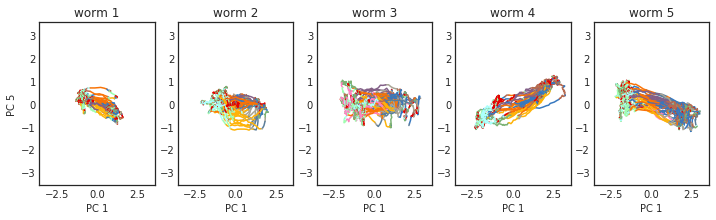

In [44]:
if D > 4:
    plt.figure(figsize=(12, 3))
    for w, (x, z) in enumerate(zip(xs, z_infs)):
        ax = plt.subplot(1, W, w+1)
        zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 4), ax=ax)
        plt.ylabel("PC 5" if w == 0 else "")
        plt.xlabel("PC 1")    
        plt.title("worm {}".format(w+1))  

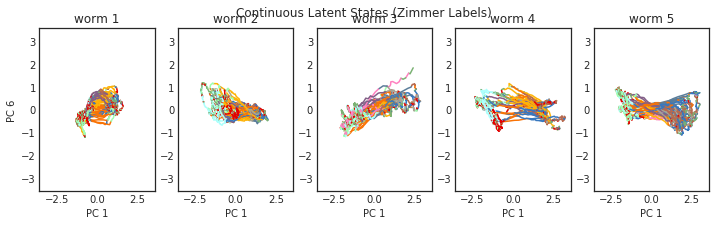

In [45]:
if D > 5:
    plt.figure(figsize=(12, 3))
    for w, (x, z) in enumerate(zip(xs, z_infs)):  
        ax = plt.subplot(1, W, w+1)
        zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 5), ax=ax)
        plt.ylabel("PC 6" if w == 0 else "")
        plt.xlabel("PC 1")    
        plt.title("worm {}".format(w+1))

    plt.suptitle("Continuous Latent States (Zimmer Labels)")

# Compare inferred and manually labeled states

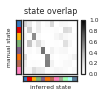

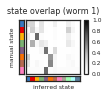

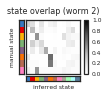

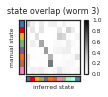

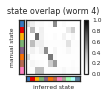

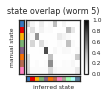

In [46]:
zplt.plot_state_overlap(z_infs, z_trues)

windows blue : REVSUS
red : SLOW
amber : VT
faded green : FWD
dusty purple : DT
orange : REV2
clay : REV1
pink : NOSTATE


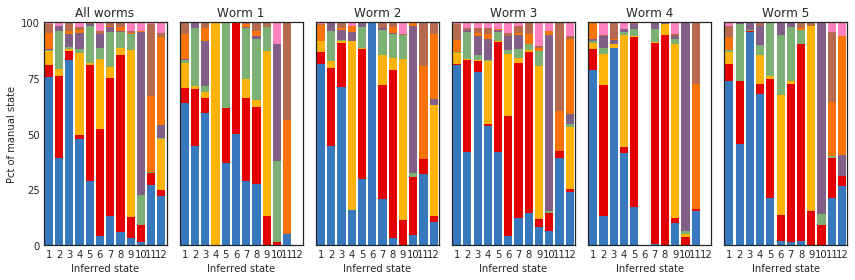

In [47]:
# Helper function to find overlap percentages
def compute_pct_overlap(zi, ztr):
    overlap = np.zeros((best_hhmm_K, K_true))
    for k in range(best_hhmm_K):
        overlap[k] = np.bincount(ztr[zi == k], minlength=K_true).astype(float)
        overlap[k] /= (overlap[k].sum() + 1e-3)
    return overlap

# Find a permutation so that the bar codes look progressive
total_overlap = compute_pct_overlap(np.concatenate(z_infs), np.concatenate(z_trues))
overlap_perm = np.argsort(np.argmax(total_overlap, axis=1))

# Helper function to plot "barcodes"
def plot_overlap_barcode(ax, overlap):
    for i,k in enumerate(overlap_perm):        
        for ktr in range(K_true):
            plt.bar(i, overlap[k, ktr], bottom=np.sum(overlap[k, :ktr]), color=zplt.default_colors[ktr], width=0.8)
    ax.set_xlim(-.5, best_hhmm_K-.5)
    
# Plot all overlaps as bar codes
plt.figure(figsize=(12, 4))

# Plot the total overlap first
ax = plt.subplot(1, W+1, 1)
plot_overlap_barcode(ax, total_overlap)
plt.ylabel("Pct of manual state")
plt.yticks([0, .25, .5, .75, 1], [0, 25, 50, 75, 100])
plt.ylim(0, 1)
plt.xlabel("Inferred state")
plt.xticks(np.arange(best_hhmm_K), np.arange(best_hhmm_K)+1)
plt.title("All worms")

for w in range(W):
    ax = plt.subplot(1, W+1, w+2)
    overlap_w = compute_pct_overlap(z_infs[w], z_trues[w])
    plot_overlap_barcode(ax, overlap_w)
    plt.yticks([])        
    plt.ylim(0, 1)
    plt.xlabel("Inferred state")
    plt.xticks(np.arange(best_hhmm_K), np.arange(best_hhmm_K)+1)
    plt.title("Worm {}".format(w+1))
plt.tight_layout()

# Print key
for color_name, state_name in zip(zplt.color_names, z_true_key):
    print("{} : {}".format(color_name, state_name))